# Cross-Sectional Area Based Filter

---

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Rectangle
from matplotlib.offsetbox import DrawingArea
import warnings
from PIL import Image
import cv2
warnings.filterwarnings('ignore')

Let's fire up our local cluster

In [2]:
cluster = LocalCluster()  
# display(cluster)

Now, we can access our dataset which is stored in a `Xarray.DataTree` object

In [3]:
dt_camp2ex = xr.backends.api.open_datatree(
    '../data/camp2ex_dtree2.zarr', 
    engine='zarr', 
    consolidated=True, 
    chunks={}
)

Then, we can access the HVPS data by using the path `"/Lear/HVPS"`

In [4]:
xr_hvps = dt_camp2ex["/Lear/HVPS"].to_dataset()

In [5]:
display(xr_hvps)

<xarray.Dataset> Size: 279MB
Dimensions:        (time: 136130, diameter: 61)
Coordinates:
  * diameter       (diameter) float64 488B 150.0 300.0 ... 4.357e+04 4.656e+04
  * time           (time) datetime64[ns] 1MB 2019-09-07T00:29:45 ... 2019-09-...
Data variables: (12/16)
    Temp           (time) float64 1MB ...
    a_bin          (time, diameter) float64 66MB ...
    cnt_bin        (time, diameter) float64 66MB ...
    conc           (time) float64 1MB ...
    d_d            (diameter) float64 488B ...
    effectiveDiam  (time) float64 1MB ...
    ...             ...
    meanDiameter   (time) float64 1MB ...
    meanVolDiam    (time) float64 1MB ...
    psd            (time, diameter) float64 66MB ...
    sv             (time) float64 1MB ...
    totaln         (time) float64 1MB ...
    twc            (time) float64 1MB ...
Attributes:
    aircraft:    Learjet
    bin_cent:    [150.0, 300.0, 450.0, 600.0, 750.0, 900.0, 1050.0, 1200.0, 1...
    dsizes:      [150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150...
    instrument:  HVPS
    psd_units:   [' #/liter/um']
    sizes:       [75.0, 225.0, 375.0, 525.0, 675.0, 825.0, 975.0, 1125.0, 127...
    type:        HVPS

Now, we can estimate the axis ratio ($\alpha$) defined by Andsager et al. (1998)

In [6]:
# lets create a array from the min diameter to the max diameter every 0.1
diameter= np.arange(xr_hvps.diameter.min() / 1e3, xr_hvps.diameter.max() / 1e3, 0.1)
ar_andsager = lambda d: 1.0048 + 0.0057 * d - 2.628 * d ** 2 + 3.682 * d ** 3 - \
                                                          1.677 * d ** 4
# axis ratio for the diameter array
alpha = ar_andsager(diameter/10)
# axis ratio for each bin within the HVPS
alpha_hvps = ar_andsager(xr_hvps.diameter/1e4)


Once we create the axis ratio, we can create a corresponding cross-sectional area

In [7]:
# area function
_area = lambda x: np.pi * (x / 2) ** 2

# Cross-sectional area for a sphere
area = _area(diameter)
# Cross-sectional area at each bin 
area_hvps = _area(xr_hvps.diameter / 1e3)

Splashed particle was detected during a cloud penetration by the Learjet aircraft on `2019-09-07 02:32:12`

In [8]:
time = "2019-09-07 02:32:12"

Let's extract the PSD and the bin width for this measurement

In [9]:
psd = (xr_hvps.sel(time=time).psd * 1e6) 
d_D = xr_hvps.sel(time=time).d_d

Now, we can compute the raw LWC and get the Nevzorov values

In [10]:
lwc_raw = ((np.pi / (6*1000)) * psd * (xr_hvps.diameter/1e3) ** 3 * d_D / 1e3)
lwc_raw_tot = lwc_raw.sum("diameter").squeeze().values
lwc_nev = xr_hvps.twc.sel(time=time).values

The Cross-sectional Area (CSA) for each bin can be estimated as:

$$CSA_{i} = \frac{A_{i}}{PN_{i}}$$

Where $A$ is the Area at each $i$ bin, and PN is the number of particles within the $i$ bin. 

In [11]:
csa = xr_hvps.a_bin.sel(time=time) /  xr_hvps.cnt_bin.sel(time=time)

Our cross-sectional area-based filter is expressed as:

$$CSAB= \frac{\pi}{4}D^2*\alpha$$

Now, we can filter bins with the axis ratio $ 1<= \alpha <=2$ 

In [12]:
## Particles accepted
csab_in = csa.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)
## Particles Rejected in the upper bound
csab_low = csa.where(csa < area_hvps / 1e5 * alpha_hvps)
## Particles Rejected in the lower bound
csab_up = csa.where(csa > area_hvps / 1e5 * alpha_hvps * 2)

Let's estimate the LWC filtered

In [13]:
lwc_filt = lwc_raw.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)


To confirm the measurements were taken within a cloud, we only keep data with at least 5 consecutive bins wiht $PN > 0$. Therefore, we created the following fucntion:

In [14]:
def filter_consecutive(dataarray, min_length=5):
    # Ensure the input is a DataArray
    if not isinstance(dataarray, xr.DataArray):
        raise TypeError("Input must be an xarray DataArray.")
    
    # Convert the DataArray to a numpy array for manipulation
    arr = dataarray.values
    arr = np.array(arr, dtype=float)  # Ensure it is of float type to accommodate NaNs
    
    # Identify the indices where the values are neither NaNs nor zeros
    valid_indices = np.where(~np.isnan(arr) & (arr != 0))[0]
    
    # If there are no valid numbers, return an array filled with NaNs
    if len(valid_indices) == 0:
        return xr.full_like(dataarray, np.nan)
    
    # Find the indices where the difference between consecutive valid indices is not 1
    diff = np.diff(valid_indices)
    breaks = np.where(diff != 1)[0] + 1
    
    # Split the valid indices into groups based on breaks
    sequences = np.split(valid_indices, breaks)
    
    # Create a copy of the array to modify
    filtered_array = np.full_like(arr, np.nan)
    
    # Retain sequences that have at least 'min_length' consecutive elements
    for seq in sequences:
        if len(seq) >= min_length:
            filtered_array[seq] = arr[seq]
    
    # Create a new DataArray with the same coordinates, dimensions, and attributes
    filtered_dataarray = xr.DataArray(filtered_array, 
                                      coords=dataarray.coords, 
                                      dims=dataarray.dims, 
                                      attrs=dataarray.attrs)
    
    return filtered_dataarray

In [15]:
lwc_filtered = filter_consecutive(lwc_filt).sum("diameter").squeeze().values

In [16]:
lwc_filtered

array(5.95016012)

Now, we get the diameter for each filtered case

In [17]:
# similarly we stimated the 
y = xr_hvps.psd.sel(time=time) * 1e6
y = y.where(y > 0, np.nan)
yyes = y.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)
ynot = y.where(csa < area_hvps / 1e5 * alpha_hvps)
ynot2 = y.where(csa > area_hvps / 1e5 * alpha_hvps * 2)

Finally, we can reproduce Figure 3 from Ladino Et al. 2024

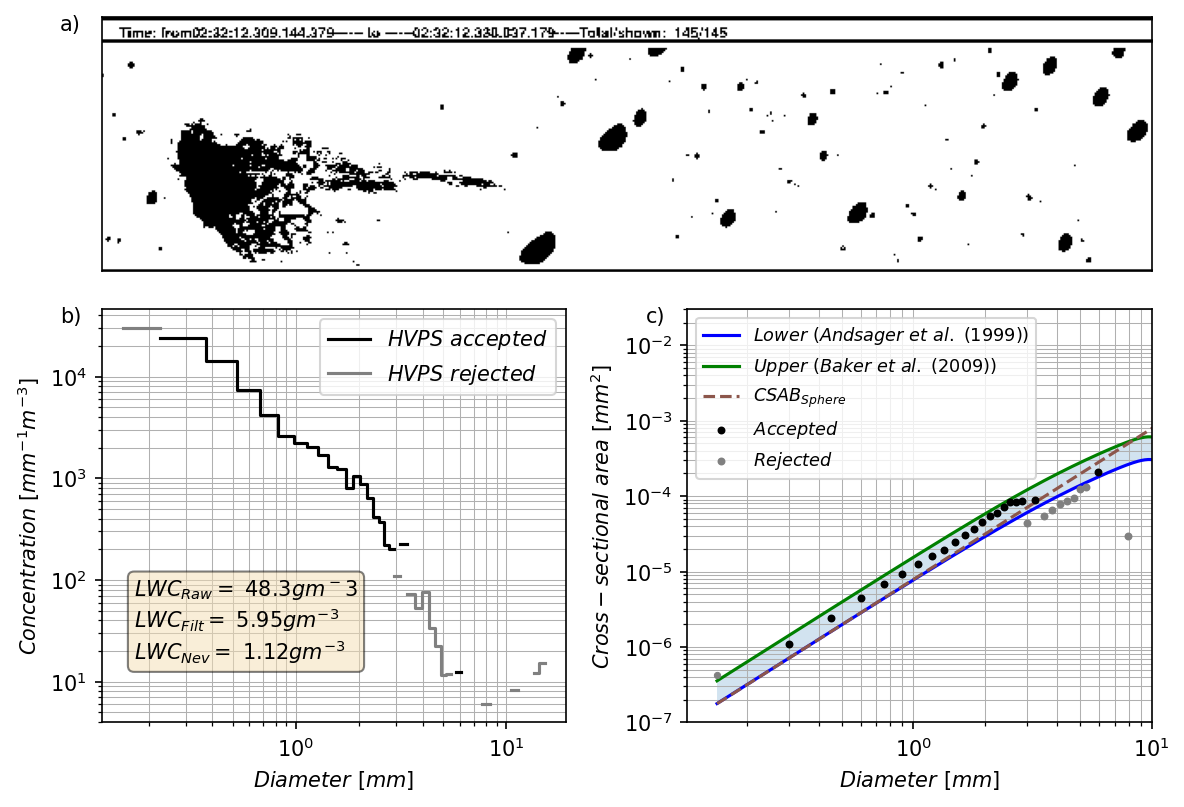

In [18]:
# Create and define the layout
fig, axs = plt.subplot_mosaic([['a)', 'a)'], ['b)', 'c)']], figsize=(8,6), dpi=150)

# In the top row show the HVPS raw image
path_img = '../data/CAMP2Ex_HVPS_P3B_V_20190907_023212_276415_RA.png'
img = np.asarray(Image.open(path_img))
ax0  = axs["a)"]
ax0.imshow(cv2.cvtColor(img[292:440, :], cv2.COLOR_BGR2RGB))
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.yaxis.set_tick_params(labelleft=False)
ax0.set_xticks([])
ax0.set_yticks([])

# Plot PSD along with LWC quantities
ax1 = axs['b)']
ax1.step(x=xr_hvps.diameter* 1e-3, y=yyes, where='mid', label='$HVPS \ accepted$', c='k')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot, where='mid', c='grey', label='$HVPS \ rejected$')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot2, where='mid', c='grey')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(which='both', lw=0.5)
ax1.set_ylabel('$Concentration \ [mm^{-1} m^{-3}]$')
ax1.set_xlabel('$Diameter \ [mm]$')
ax1.legend(fontsize=10)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.text(0.07, 0.35, "$LWC_{Raw}= \ $" + f'{lwc_raw_tot:.1f}' + f'$gm^{-3}$' + '\n' + 
         "$LWC_{Filt}=\  $" + f"{lwc_filtered:.2f}" + '$gm^{-3}$' + '\n' +
         "$LWC_{Nev}=\  $" + f"{lwc_nev:.2f}" + '$gm^{-3}$',
        transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)


# Plot the CSAB filter rejectec particles
ax = axs['c)']
ax.plot(diameter,area/1e5 * alpha, c='b', label='$Lower \ (Andsager \ et \  al. \ (1999))$')
ax.plot(diameter,area/1e5 * alpha * 2, c='g', label='$Upper \  (Baker \  et \  al. \  (2009))$')
ax.plot(diameter , area/1e5,  color='tab:brown', ls='--', label='$CSAB_{Sphere}$')
ax.fill_between(diameter, 
                area/1e5 * alpha , 
                area/1e5 * alpha * 2, alpha=0.2)

ax.scatter(xr_hvps.diameter / 1e3, csab_in, 
               zorder=2.5, c='k', lw=0.8, marker='.', label='$Accepted$')
ax.scatter(xr_hvps.diameter / 1e3, csab_low, 
               zorder=2.5, c='gray', lw=0.8, marker='.', label='$Rejected$')
ax.scatter(xr_hvps.diameter / 1e3, csab_up, 
               zorder=2.5, c='gray', lw=0.5, marker='.')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$Cross-sectional \ area \ [mm^2]$')
ax.set_xlabel('$Diameter \ [mm]$')
# title = f"{pd.to_datetime(xr_hvps.a_bin.sel(time=time).time.values): %Y-%m-%d %X} UTC - {aircraft}"
# fig.suptitle(title, fontsize=14, fontweight='bold', y=0.95)
ax.set_xlim(0, 10)
ax.set_xlim(0, 10)

ax.legend(loc='upper left', fontsize=8.5)
ax.grid(which='both', lw=0.5)
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-20/72, 1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
fig.tight_layout()
plt.subplots_adjust(wspace=None, hspace=-0.1)
plt.savefig('../images/area_based_filter.svg', bbox_inches='tight')